In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

## Prepare Data

In [2]:
batch_size = 256
img_size = (28, 28)
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def prepare(ds: tf.data.Dataset):
    rescale = lambda x: (tf.cast(x, tf.float32)-127.5)/127.5
    
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1024).batch(batch_size).prefetch(AUTOTUNE).cache()

    return ds

In [4]:
ds = tfds.load("mnist", split="train+test", as_supervised=True)
ds = prepare(ds)

In [5]:
def show_batch(batch, num=16):
    plt.figure(figsize=(5, 5))
    for i in range(num):
        plt.subplot(4, 4, i+1)
        plt.imshow(batch[i, :, :, 0], cmap="gray")
        plt.axis("off")

In [6]:
ds_iter = ds.as_numpy_iterator()

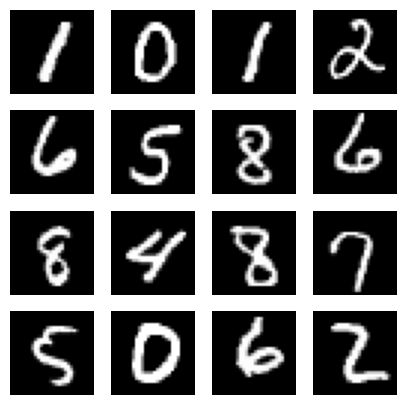

In [7]:
batch = ds_iter.next()
show_batch(batch[0])

## Conditional GAN

In [8]:
from keras import layers

In [9]:
latent_size = 100
embedding_size = 50
n_classes = 10

### Generator

In [10]:
def build_generator():
    # Label input
    label_input = layers.Input((1,))
    li = layers.Embedding(n_classes, embedding_size)(label_input)
    li = layers.Dense(7*7, use_bias=False)(li)
    li = layers.Reshape((7, 7, 1))(li)

    # Latent input
    latent_input = layers.Input((latent_size,))
    l = layers.Dense(7*7*256, use_bias=False)(latent_input)
    l = layers.BatchNormalization()(l)
    l = layers.LeakyReLU()(l)
    l = layers.Reshape((7, 7, 256))(l)

    # Concatenate inputs
    gen_input = layers.Concatenate()([li, l])

    # Generator Convs
    gen = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(gen_input)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)

    gen = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU()(gen)

    gen = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh")(gen)
    gen = layers.BatchNormalization()(gen)

    model = tf.keras.Model([label_input, latent_input], gen)

    model.compile()

    return model

In [11]:
gen = build_generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 12544)        1254400     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                              

### Test Generator

(-0.5, 27.5, 27.5, -0.5)

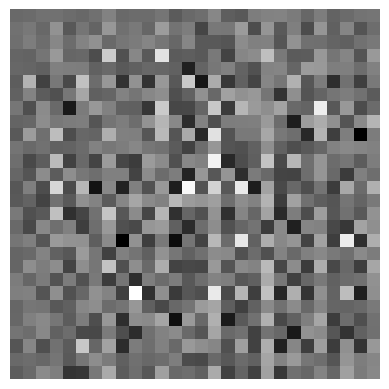

In [12]:
noise = tf.random.normal([1, latent_size])
label = tf.expand_dims(1, axis=0)

gen_img = gen([label, noise])

plt.imshow(gen_img[0, :, :, 0], cmap="gray")
plt.axis("off")

### Discriminator

In [13]:
def build_dicriminator():
    # Label input
    label_input = layers.Input((1,))
    li = layers.Embedding(n_classes, embedding_size)(label_input)
    li = layers.Dense(28*28, use_bias=False)(li)
    li = layers.Reshape((28, 28, 1))(li)

    # Image input
    image_input = layers.Input((28, 28, 1))

    # Concatenate inputs
    dis_input = layers.Concatenate()([li, image_input])

    # Discriminator Convs
    dis = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(dis_input)
    dis = layers.LeakyReLU()(dis)
    dis = layers.Dropout(0.3)(dis)

    dis = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(dis)
    dis = layers.LeakyReLU()(dis)
    dis = layers.Dropout(0.3)(dis)

    dis = layers.Flatten()(dis)
    dis = layers.Dense(1)(dis)

    model = tf.keras.Model([label_input, image_input], dis)

    model.compile()

    return model

#### Testing Discriminator

In [14]:
dis = build_dicriminator()

dis([label, gen_img])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00121799]], dtype=float32)>

## Building Subclassed Model

In [15]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, generator: tf.keras.Model, discriminator: tf.keras.Model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt: tf.keras.optimizers.Optimizer, d_opt: tf.keras.optimizers.Optimizer, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, data):
        images, labels = data
        noise = tf.random.normal([tf.shape(labels)[0], latent_size])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_images = self.generator([labels, noise], training=True)

            real_output = self.discriminator([labels, images], training=True)
            fake_output = self.discriminator([labels, fake_images], training=True)

            gen_loss = self.g_loss(fake_output)
            dis_loss = self.d_loss(real_output, fake_output)
        
        g_grads = g_tape.gradient(gen_loss, self.generator.trainable_variables)
        d_grads = d_tape.gradient(dis_loss, self.discriminator.trainable_variables)

        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        return {"g_loss": gen_loss, "d_loss": dis_loss}

### Losses & Optimizers

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [19]:
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

### Build GAN Model

In [20]:
cond_gan = ConditionalGAN(build_generator(), build_dicriminator())
cond_gan.compile(g_opt, d_opt, g_loss, d_loss)

#### Callbacks

In [21]:
class SaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save("models/generator.h5")
        self.model.discriminator.save("models/discriminator.h5")

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="g_loss", patience=30, restore_best_weights=True),
    SaveModel()
]

## Train Model

In [23]:
epochs = 500

In [24]:
history = cond_gan.fit(ds, epochs=epochs, callbacks=callbacks)

Epoch 1/500
274/274 [==============================] - 11s 33ms/step - g_loss: 2.7458 - d_loss: 0.2815
Epoch 2/500
274/274 [==============================] - 9s 31ms/step - g_loss: 6.3844 - d_loss: 0.0092
Epoch 3/500
274/274 [==============================] - 8s 31ms/step - g_loss: 7.5189 - d_loss: 0.0027
Epoch 4/500
274/274 [==============================] - 9s 31ms/step - g_loss: 8.0759 - d_loss: 0.0016
Epoch 5/500
274/274 [==============================] - 8s 31ms/step - g_loss: 8.3478 - d_loss: 0.0019
Epoch 6/500
274/274 [==============================] - 8s 31ms/step - g_loss: 10.2817 - d_loss: 0.0110
Epoch 7/500
274/274 [==============================] - 8s 31ms/step - g_loss: 11.6566 - d_loss: 0.0402
Epoch 8/500
274/274 [==============================] - 8s 31ms/step - g_loss: 10.7892 - d_loss: 0.0354
Epoch 9/500
274/274 [==============================] - 9s 31ms/step - g_loss: 11.0741 - d_loss: 0.0460
Epoch 10/500
274/274 [==============================] - 8s 31ms/step - g_loss

## Plot Performence

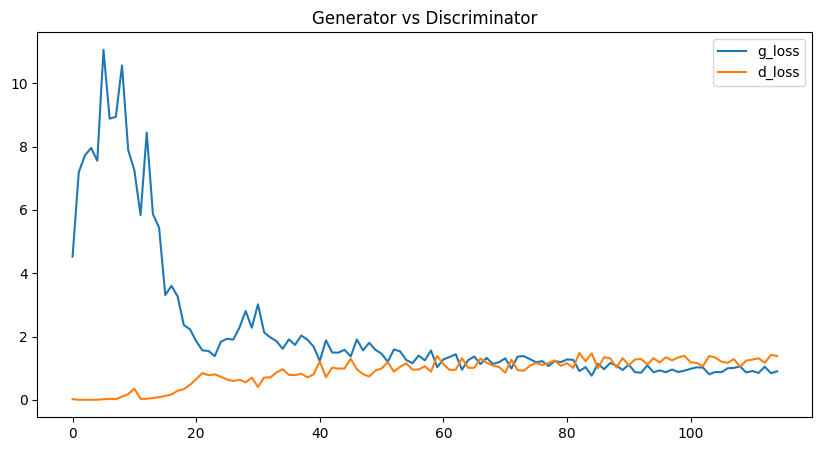

In [25]:
plt.figure(figsize=(10, 5))

plt.plot(history.history["g_loss"])
plt.plot(history.history["d_loss"])

plt.title("Generator vs Discriminator")
plt.legend(["g_loss", "d_loss"])
plt.show()

### Show Results

In [45]:
n = 16
noise = tf.random.normal([n, latent_size])
labels = tf.constant([9]*n)

fake_batch = cond_gan.generator([labels, noise])

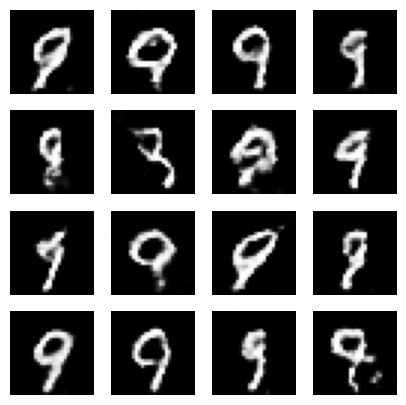

In [46]:
show_batch(fake_batch)

### Train for more epochs

In [48]:
epochs1 = 500

In [49]:
history1 = cond_gan.fit(ds, epochs=epochs1, callbacks=callbacks)

Epoch 1/500
  6/274 [..............................] - ETA: 15s - g_loss: 0.9501 - d_loss: 1.3920WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0272s vs `on_train_batch_end` time: 0.0428s). Check your callbacks.


274/274 [==============================] - 9s 32ms/step - g_loss: 1.0908 - d_loss: 1.1849
Epoch 2/500
274/274 [==============================] - 8s 31ms/step - g_loss: 1.2125 - d_loss: 1.1412
Epoch 3/500
274/274 [==============================] - 8s 30ms/step - g_loss: 1.2587 - d_loss: 1.0657
Epoch 4/500
274/274 [==============================] - 8s 30ms/step - g_loss: 1.0899 - d_loss: 1.2008
Epoch 5/500
274/274 [==============================] - 8s 30ms/step - g_loss: 1.0453 - d_loss: 1.2369
Epoch 6/500
274/274 [==============================] - 8s 31ms/step - g_loss: 1.0143 - d_loss: 1.2322
Epoch 7/500
274/274 [==============================] - 9s 31ms/step - g_loss: 0.9962 - d_loss: 1.2206
Epoch 8/500
274/274 [==============================] - 9s 31ms/step - g_loss: 1.0253 - d_loss: 1.2124
Epoch 9/500
274/274 [==============================] - 8s 30ms/step - g_loss: 1.0657 - d_loss: 1.1900
Epoch 10/500
274/274 [==============================] - 9s 31ms/step - g_loss: 1.0532 - d_loss

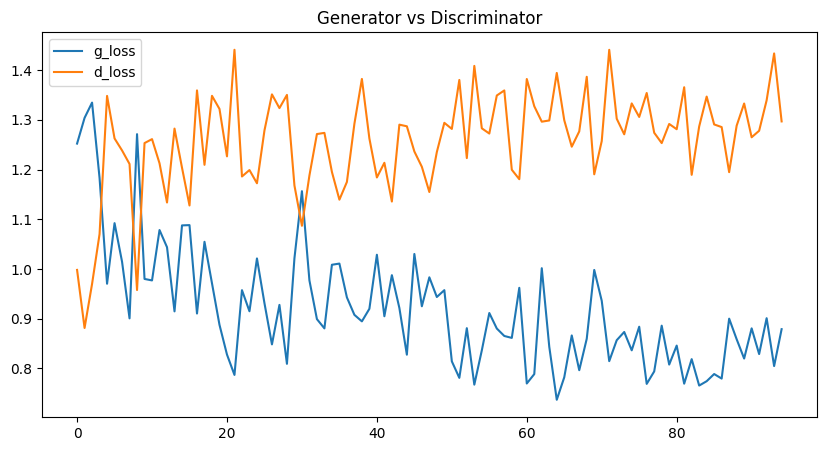

In [50]:
plt.figure(figsize=(10, 5))

plt.plot(history1.history["g_loss"])
plt.plot(history1.history["d_loss"])

plt.title("Generator vs Discriminator")
plt.legend(["g_loss", "d_loss"])
plt.show()

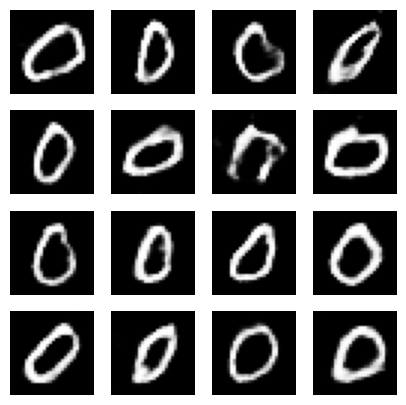

In [60]:
n = 16
noise = tf.random.normal([n, latent_size])
labels = tf.constant([0]*n)

fake_batch = cond_gan.generator([labels, noise])
show_batch(fake_batch)